# Set Covering Problem with Genetic Algorithm

In [2]:
import random
import logging
from matplotlib import pyplot as plt
from matplotlib.pyplot import title
from collections import namedtuple
from functools import reduce
import math

## Problem definition

In [3]:
def problem(N, seed=None):
    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

## Auxiliary functions

In [16]:
Individual = namedtuple('Individual', ('genome', 'fitness'))

def evaluate(genome, P):
    solution = list()
    for i, el in enumerate(genome):
        if el ==1: 
            solution.append(P[i])
    covering= set()
    covering = reduce(lambda a, b: set(a) | set(b), solution, covering)
    return len(covering), -sum(len(el) for el in solution)

def tournament(population, tournament_size=2):
    return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)

def cross_over(g1, g2, len_P):
    cut = random.randint(0, len_P)
    return g1[:cut] + g2[cut:]

def mutation(g, len_P):
    point = random.randint(0, len_P - 1)
    return g[:point] + (1 - g[point],) + g[point + 1:]

def plot_fitness(N, fitness_log, tot_gens):
    gen_best = [max(f[1] for f in fitness_log if f[0] == x) for x in range(tot_gens)]
    fig = plt.figure(figsize=(15, 6))
    fig.suptitle(f'N = {N}', fontsize=20)    
    plt.xlabel('Generation', fontsize=18)
    plt.ylabel('Fitness Value', fontsize=16)
    plt.plot([x for x, _ in enumerate(gen_best)], [y[0] for _, y in enumerate(gen_best)], label='Distinct elements')
    plt.plot([x for x, _ in enumerate(gen_best)], [-y[1] for _, y in enumerate(gen_best)], label='Total elements')
    plt.legend()
    plt.show()

## Genetic Algorithm

In [51]:
def genetic_algorithm(N,P):
    P = [tuple(_) for _ in P]
    problem_size = len(P)
    population=list()

    # Init population (size must be externally defined!)
    for genome in [tuple([0 for _ in range(problem_size)]) for _ in range(population_size)]:
        population.append(Individual(genome,evaluate(genome,P)))
    
    # Init auxiliary variables for stats and steady state detection
    fitness_log = [(0, i.fitness) for i in population]
    plateau_count = 0

    # Run algorithm at most NUM_GENS times (must be  externally defined), creating an offspring (size must be externally defined)
    # and randomly mutating or generating with xover
    for g in range(NUM_GENS):
        offspring = list()
        for i in range(offspring_size):
            if random.random() < 0.3:
                p = tournament(population, tournament_size=TOURNAMENT_SIZE)
                o = mutation(p.genome, problem_size)
            else:
                p1 = tournament(population, tournament_size=TOURNAMENT_SIZE)
                p2 = tournament(population, tournament_size=TOURNAMENT_SIZE)
                o = cross_over(p1.genome, p2.genome, problem_size)
            f = evaluate(o, P)
            fitness_log.append((g + 1, f))
            offspring.append(Individual(o, f))
        population += offspring
        population = sorted(population, key=lambda i: i.fitness, reverse=True)[:population_size]
        
        # Plateau to detect if no improvement in last 50 gens, in that case break
        if max(f[1] for f in fitness_log if f[0] == g + 1) <= max(f[1] for f in fitness_log if f[0] == g):
            plateau_count += 1
        else:
            plateau_count = 0
        
        if plateau_count == STEADY_STATE_LIMIT:
            break
    
    if population[0].fitness[0] == N:
        logging.debug(f'Solution found for N={N}: w={-population[0].fitness[1]} (bloat={int((-population[0].fitness[1]-N)*100/N)}%) after {g + 1} generations. Tournament size: {TOURNAMENT_SIZE}. Population size: {population_size}. Offspring size: {offspring_size}. Evaluated fitness {len(fitness_log)} times.')
    else:
        logging.debug('Solution not found')

    return fitness_log, g + 1

## Stats evaluation mutating Population and Offspring size

In [45]:
from numpy import linspace

NUM_GENS = 5000
SEED = 42
STEADY_STATE_LIMIT = 10

logging.getLogger().setLevel(logging.INFO)

all = list()

for N in [5, 10, 20, 100, 500, 1000]:
    best = None
    for pop_prob in linspace(1.1, 2, 5):
        population_size = math.ceil(pop_prob * N)
        for off_prob in linspace(1.1, 2, 5):
            offspring_size = math.ceil(off_prob * population_size)
            for tournament_size in range(2, min(17, 3 + N//3), 3):
                TOURNAMENT_SIZE = tournament_size
                fitness_log, run_gens = genetic_algorithm(N,problem(N,SEED))
                if best is None or max(f[1] for f in fitness_log if f[0] == run_gens) > best[0]:
                    best = (max(f[1] for f in fitness_log if f[0] == run_gens), (pop_prob, off_prob, tournament_size), run_gens)
                all.append((N, pop_prob, off_prob, tournament_size, max(f[1] for f in fitness_log if f[0] == run_gens), run_gens))
    logging.info(f'Best solution for N = {N} is {best}')

INFO:root:Best solution for N = 5 is ((5, -5), (1.1, 1.3250000000000002, 2), 15)
INFO:root:Best solution for N = 10 is ((10, -10), (1.1, 2.0, 5), 16)
INFO:root:Best solution for N = 20 is ((20, -24), (1.1, 1.775, 2), 21)
INFO:root:Best solution for N = 100 is ((100, -193), (2.0, 2.0, 14), 16)
INFO:root:Best solution for N = 500 is ((500, -1388), (1.3250000000000002, 1.775, 11), 18)
INFO:root:Best solution for N = 1000 is ((1000, -3266), (1.3250000000000002, 1.3250000000000002, 8), 26)


In [47]:
import pandas as pd
import os
import time

try:
    data = pd.DataFrame(all, columns=['N', 'Pop_Prob', 'Off_Prob', 'Tournament_Size', 'Value', 'Run_Gens'])
    old_data = False
except:
    data = None
    assert os.path.exists('stats/stats.csv'), 'Yeuch, there are no data!'
    old_data = True

if old_data:
    data = pd.read_csv('stats/stats.csv', index_col=None)

data.sort_values(['N', 'Value', 'Run_Gens'], ascending=[True, False, True], inplace=True)

for N in data.N.unique():
    print(data[data.N == N].head(1).to_markdown())

if not old_data:
    if os.path.exists('stats/stats.csv'):
        os.rename('stats/stats.csv', f'stats/stats_{time.time_ns()}.csv')
    data.to_csv('stats/stats.csv', columns=['N', 'Pop_Prob', 'Off_Prob', 'Tournament_Size', 'Value', 'Run_Gens'], index=False)



|    |   N |   Pop_Prob |   Off_Prob |   Tournament_Size | Value   |   Run_Gens |
|---:|----:|-----------:|-----------:|------------------:|:--------|-----------:|
|  8 |   5 |      1.325 |      1.775 |                 2 | (5, -5) |         13 |
|    |   N |   Pop_Prob |   Off_Prob |   Tournament_Size | Value     |   Run_Gens |
|---:|----:|-----------:|-----------:|------------------:|:----------|-----------:|
| 60 |  10 |      1.775 |       1.55 |                 5 | (10, -10) |         15 |
|    |   N |   Pop_Prob |   Off_Prob |   Tournament_Size | Value     |   Run_Gens |
|---:|----:|-----------:|-----------:|------------------:|:----------|-----------:|
| 84 |  20 |        1.1 |      1.775 |                 2 | (20, -24) |         21 |
|     |   N |   Pop_Prob |   Off_Prob |   Tournament_Size | Value       |   Run_Gens |
|----:|----:|-----------:|-----------:|------------------:|:------------|-----------:|
| 274 | 100 |          2 |          2 |                14 | (100, -193) |   

## Solve problem

DEBUG:root:Solution found for N=5: w=5 (bloat=0%) after 53 generations. Tournament size: 2. Population size: 7. Offspring size: 13. Evaluated fitness 696 times.
DEBUG:root:Solution found for N=10: w=10 (bloat=0%) after 55 generations. Tournament size: 5. Population size: 18. Offspring size: 28. Evaluated fitness 1558 times.
DEBUG:root:Solution found for N=20: w=24 (bloat=20%) after 61 generations. Tournament size: 2. Population size: 22. Offspring size: 40. Evaluated fitness 2462 times.
DEBUG:root:Solution found for N=100: w=193 (bloat=93%) after 56 generations. Tournament size: 14. Population size: 200. Offspring size: 400. Evaluated fitness 22600 times.
DEBUG:root:Solution found for N=500: w=1388 (bloat=177%) after 58 generations. Tournament size: 11. Population size: 663. Offspring size: 1177. Evaluated fitness 68929 times.
DEBUG:root:Solution found for N=1000: w=3266 (bloat=226%) after 66 generations. Tournament size: 8. Population size: 1326. Offspring size: 1757. Evaluated fitnes

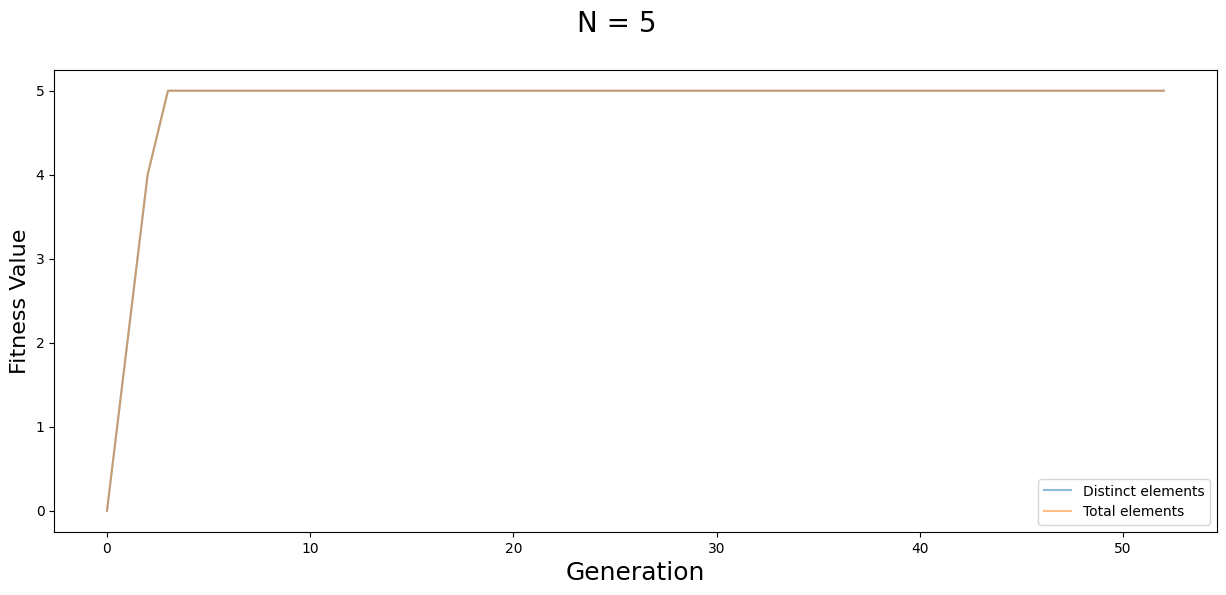

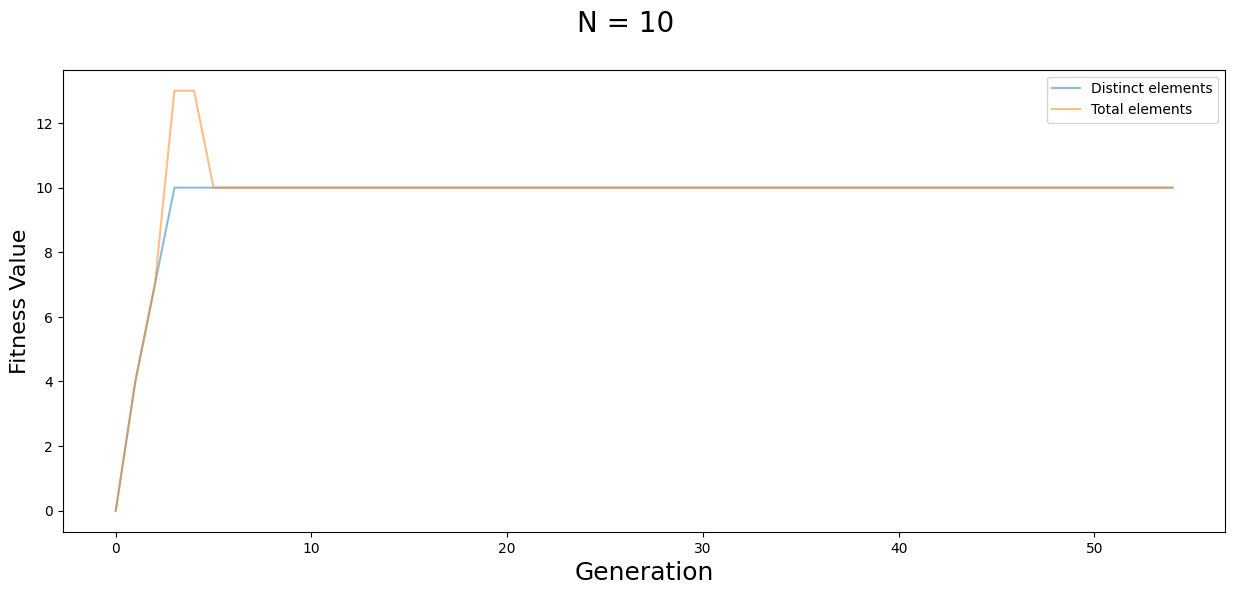

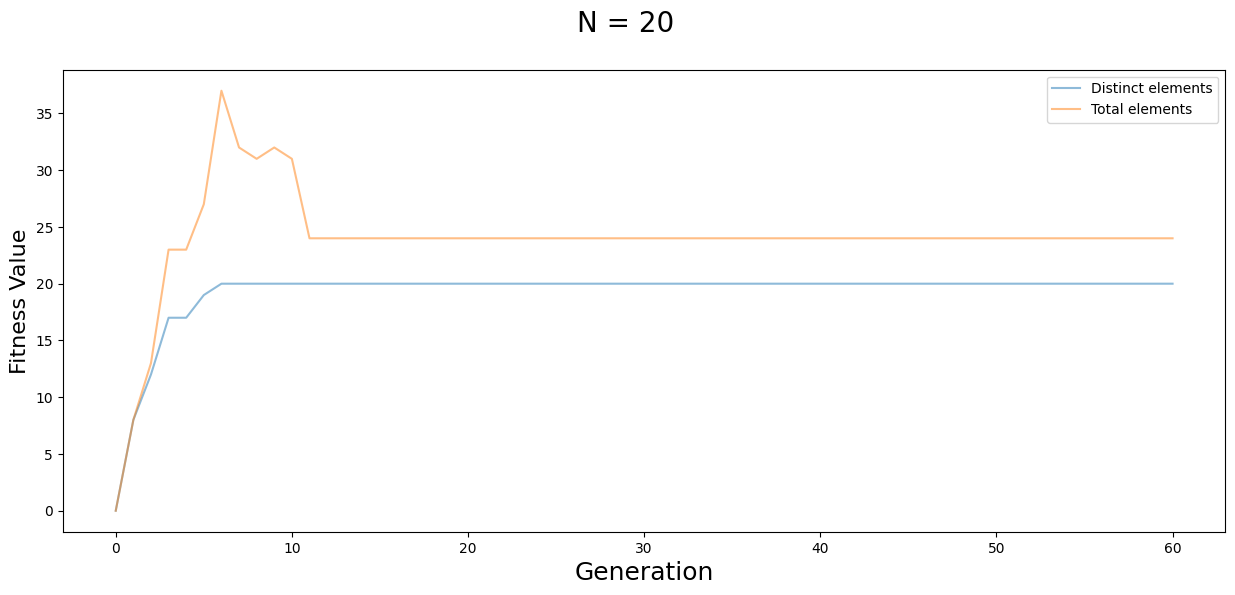

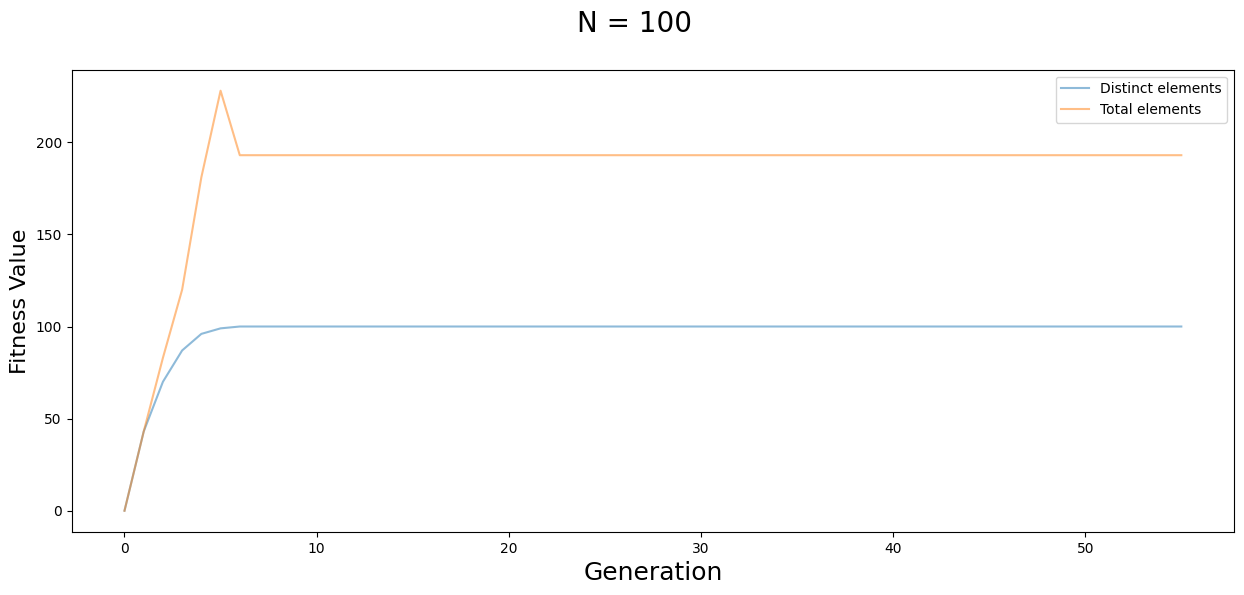

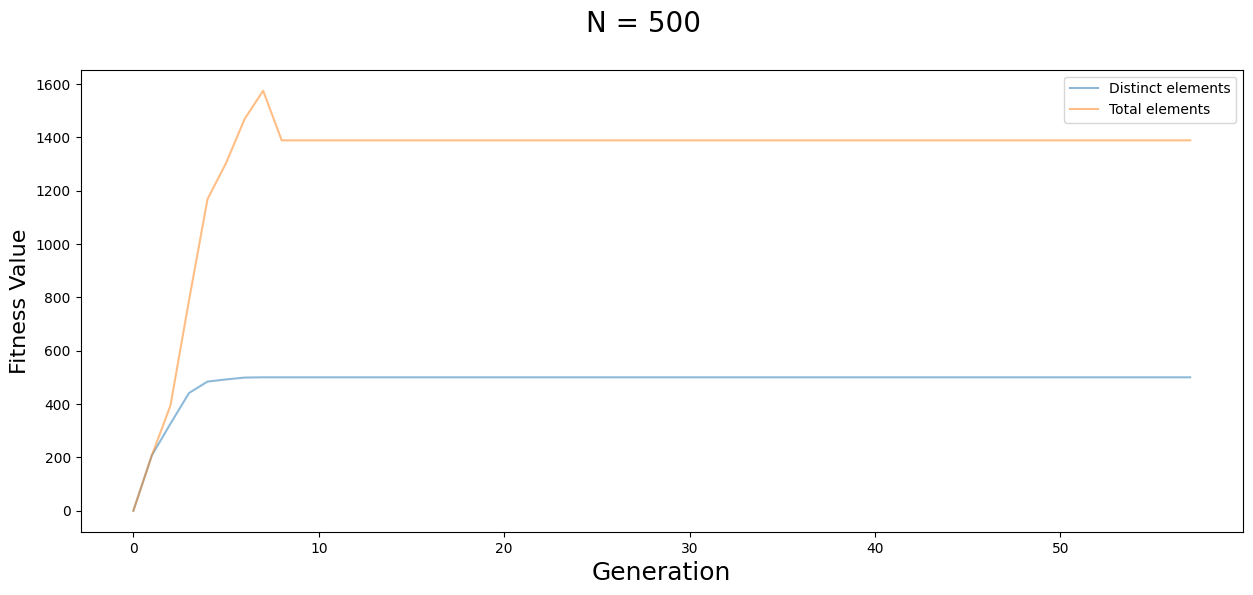

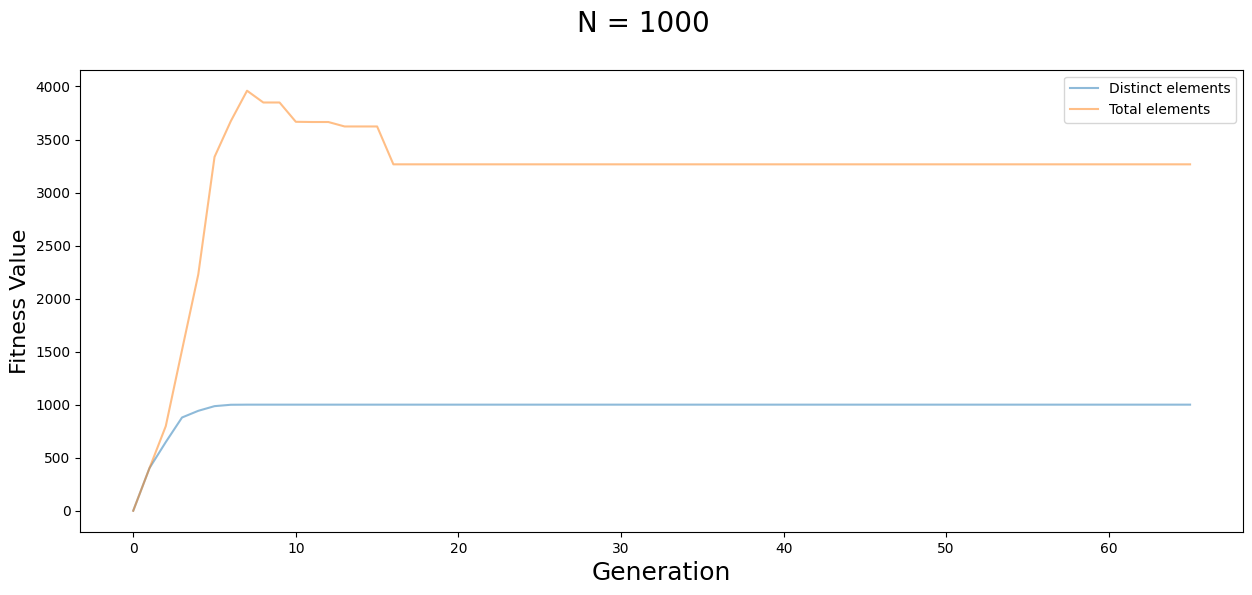

In [61]:
NUM_GENS = 5000
SEED = 42
STEADY_STATE_LIMIT = 10     # Higher values just increase computation time

logging.getLogger().setLevel(logging.DEBUG)

# Based on empirical analysis, I chose a population size factor of 2 (wrt N) and an offspring size factor of 1.625 (wrt population size)
stats = dict()
best_pars = {
    5: (1.3250000000000002, 1.775, 2),
    10: (1.775,  1.55, 5),
    20: (1.1, 1.775, 2),
    100: (2, 2, 14),
    500: (1.3250000000000002, 1.775, 11),
    1000: (1.3250000000000002, 1.3250000000000002, 8)
}

for N in [5, 10, 20, 100, 500, 1000]:
    pop_prob, off_prob, TOURNAMENT_SIZE = best_pars[N]
    population_size = math.ceil(pop_prob * N)
    offspring_size = math.ceil(off_prob * population_size)
    fitness_log, run_gens = genetic_algorithm(N, problem(N,SEED))
    stats[N] = (fitness_log, run_gens)

logging.getLogger().setLevel(logging.INFO)

for N, i in stats.items():
    fitness_log, run_gens = i
    plot_fitness(N, fitness_log, run_gens)